In [253]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN
import subject_data
from subject_data import SubjectData

# Load Data

Synthetic subject, always reports low confidence for partner 1, high for partner 2

In [248]:
features = ['Sconfidence_prev', 'type_prev', 'type']

type_prev = np.random.permutation(np.concatenate((2*np.ones((200,10)), np.ones((400, 10)))))

# shift the type by 1 for type_prev
type = np.concatenate((type_prev[:-1,:], np.zeros((1,10))))
confidence_prev = type_prev - 1

# padding
type_prev_padded = np.concatenate((np.zeros((1,10)), type_prev))
confidence_prev_padded = np.concatenate((np.zeros((1,10)), confidence_prev))
type_padded = np.concatenate((type, -1*np.ones((1,10))))

data = np.stack((confidence_prev_padded, type_prev_padded, type_padded), axis=2)
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,10,)))).reshape(601,10,1)

print(data.shape, target.shape)
batch_size = 2

train = DatasetRNN(data, target, batch_size)

(601, 10, 3) (601, 10, 1)


In [249]:
# check data
print('[Sconfidence previous, type previous, type]   [Sconfidence(target)]')
for i in range(20):
    print(data[i,0,:], target[i,0])

[Sconfidence previous, type previous, type]   [Sconfidence(target)]
[0. 0. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 1.] [0.]


Synthetic subject as above + noise sampled from normal distribution with mean 0 and std 1

In [260]:
features = ['Sconfidence_prev', 'type_prev', 'type']

type_prev = np.random.permutation(np.concatenate((2*np.ones((200,10)), np.ones((200, 10)))))

# shift the type by 1 for type_prev
type = np.concatenate((type_prev[:-1,:], np.zeros((1,10))))
confidence_noisy = type_prev - 1 + np.random.normal(0, 0.5, (400,10))

# thresholding to get binary values back
confidence_prev = np.where(confidence_noisy < 0.5, 0, 1)

# padding
type_prev_padded = np.concatenate((np.zeros((1,10)), type_prev))
confidence_prev_padded = np.concatenate((np.zeros((1,10)), confidence_prev))
type_padded = np.concatenate((type, -1*np.ones((1,10))))

data = np.stack((confidence_prev_padded, type_prev_padded, type_padded), axis=2)
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,10,)))).reshape(401,10,1)

print(data.shape, target.shape)
batch_size = 2

train = DatasetRNN(data, target, batch_size)

(401, 10, 3) (401, 10, 1)


(array([ 3.,  0.,  5., 14., 17., 24., 31., 42., 31., 37., 30., 37., 40.,
        30., 25.,  9., 12.,  8.,  4.,  1.]),
 array([-1.38061038, -1.19123666, -1.00186294, -0.81248922, -0.6231155 ,
        -0.43374178, -0.24436806, -0.05499434,  0.13437938,  0.3237531 ,
         0.51312682,  0.70250054,  0.89187426,  1.08124798,  1.2706217 ,
         1.45999542,  1.64936914,  1.83874286,  2.02811658,  2.2174903 ,
         2.40686402]),
 <BarContainer object of 20 artists>)

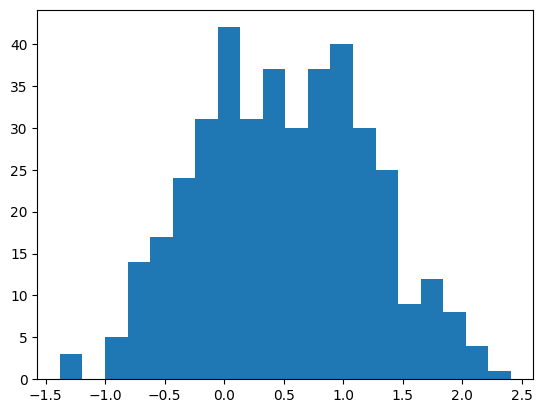

In [261]:
plt.hist(confidence_noisy[:,1], bins=20)

In [262]:
np.unique(confidence_prev[:,1], return_counts=True)

(array([0, 1]), array([203, 197], dtype=int64))

In [245]:
# check data
print('[Sconfidence previous, type previous, type]   [Sconfidence(target)]')
for i in range(20):
    print(data[i,0,:], target[i,0])

[Sconfidence previous, type previous, type]   [Sconfidence(target)]
[0. 0. 2.] [0.]
[0. 2. 2.] [0.]
[0. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [0.]
[0. 2. 1.] [0.]
[0. 1. 1.] [1.]
[1. 1. 1.] [1.]
[1. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 1.] [0.]
[0. 1. 1.] [0.]
[0. 1. 2.] [1.]
[1. 2. 2.] [1.]
[1. 2. 2.] [1.]


Actual values of Sconfidence, Pconfidence and type

In [288]:
data_dir = '..\data\data_for_Meike.mat'
matDf = loadmat(data_dir)['data']
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=matDf.dtype.names).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

features = ['Sconfidence_prev', 'Pconfidence_prev', 'type_prev', 'type']

df['Sconfidence'] = df.groupby(['subject', 'block'])['Sreport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))
df['Pconfidence'] = df.groupby(['subject', 'block'])['Preport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))

# Subject 1
df_1 = df[df['subject'] == 1]

Pconfidence_prev = np.array(df_1['Pconfidence']).reshape(64,4, order='F')
type_prev = np.array(df_1['type'], dtype=int).reshape(64,4, order='F')

#Sconfidence_prev = np.random.random_integers(0, 1, size=(len(df_1))).reshape(64,4, order='F')
Sconfidence_prev = np.array(df_1['Sconfidence']).reshape(64,4, order='F')
type = np.concatenate((type_prev[:-1,:], np.zeros((1,4))))

# padding
Pconfidence_prev_padded = np.concatenate((np.zeros((1,4)), Pconfidence_prev))
type_prev_padded = np.concatenate((np.zeros((1,4)), type_prev))
Sconfidence_prev_padded = np.concatenate((np.zeros((1,4)), Sconfidence_prev))
type_padded = np.concatenate((type, -1*np.ones((1,4))))

data = np.stack((Sconfidence_prev_padded, Pconfidence_prev_padded, type_prev_padded, type_padded), axis=2)

# target is current Sconfidence
target =  np.concatenate((data[1:,:,0], -1*np.ones((1,4,)))).reshape(65,4,1)

print(data.shape, target.shape)
batch_size = 2
train = DatasetRNN(data, target, batch_size)

(65, 4, 4) (65, 4, 1)


In [290]:
# check values
print('[Sconfidence previous, Pconfidence previous, type previous, type]   [Sconfidence(target)]')
for i in range(50,64):
    print(data[i,0,0], target[i,0])

[Sconfidence previous, Pconfidence previous, type previous, type]   [Sconfidence(target)]
0.0 [0.]
0.0 [0.]
0.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [0.]
0.0 [1.]
1.0 [0.]
0.0 [1.]
1.0 [0.]
0.0 [1.]
1.0 [0.]


Set up Disentangled RNN

In [275]:
n_features = len(features)
target_size = 2
latent_size = 5
hidden_size = int(np.ceil(np.mean([n_features, target_size])))
obs_size = n_features

# Number of hidden units in each of the two layers of the choice MLP.
update_mlp_shape = (3,3,)
choice_mlp_shape = (target_size,) 

def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size,
      beta_scale=1)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(
          obs_size = obs_size,
          latent_size = latent_size,
          update_mlp_shape = update_mlp_shape,
          choice_mlp_shape = choice_mlp_shape,
          target_size=target_size,
          eval_mode=True,
          beta_scale=1)               
  return model

optimizer = optax.adam(learning_rate=1e-2)

Fit disRNN with no penalty at first, to get good quality-of-fit

Step 2000 of 2000; Loss: 7.5085e+01. (Time: 31.2s)

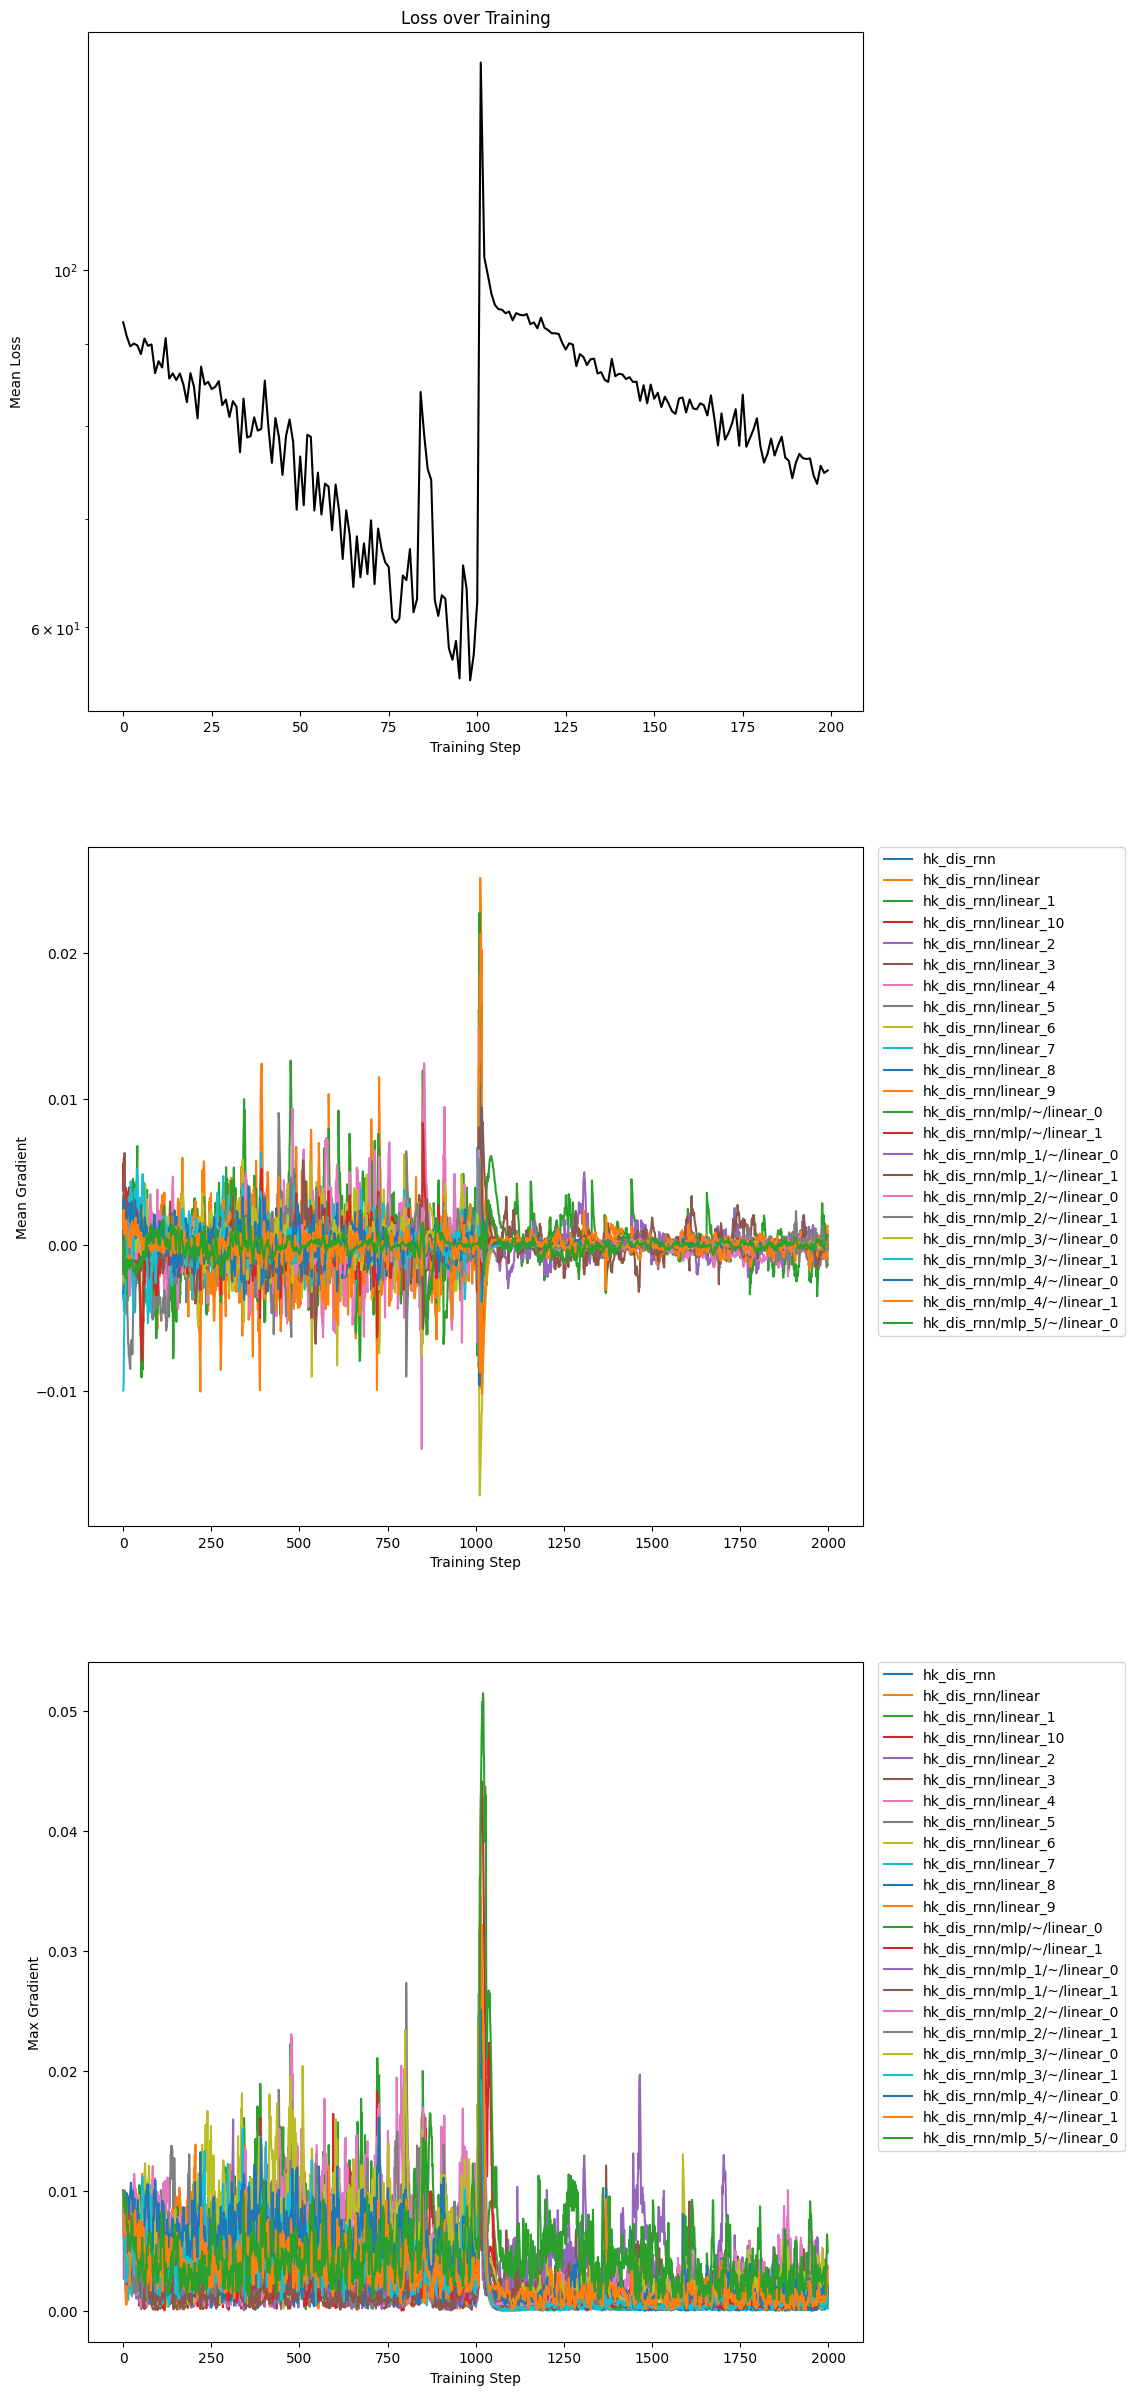

In [284]:
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=None,
)

# Calculate Normalized likelihoods

In [289]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood, training_output = subject_data.compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 42.2%


(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: title={'center': 'Latent Bottlenecks'}, ylabel='Latent #'>,
        <Axes: title={'center': 'Update MLP Bottlenecks'}, ylabel='Latent #'>],
       dtype=object))

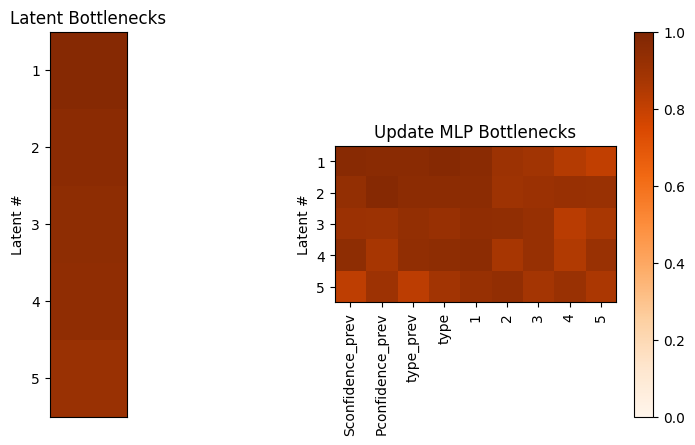

In [201]:
disrnn.plot_bottlenecks(disrnn_params, obs_names=features)

In [286]:
xs, actual_choices = next(train) # performance for the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

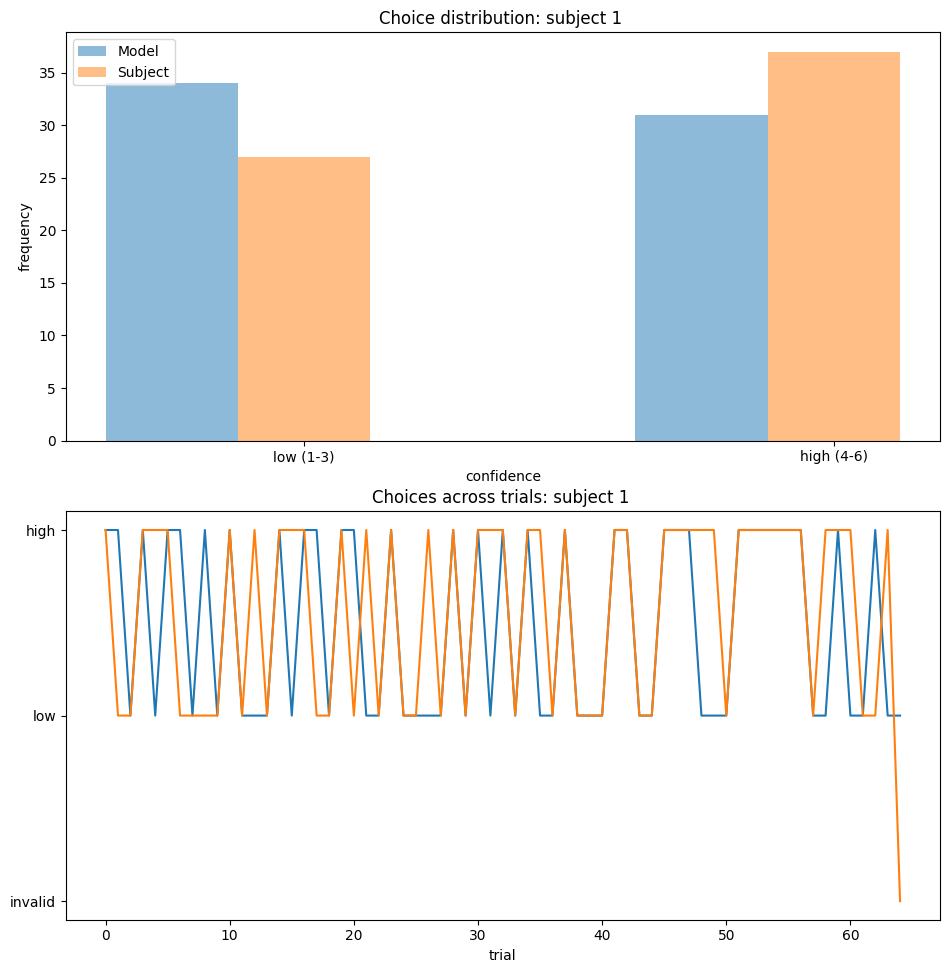

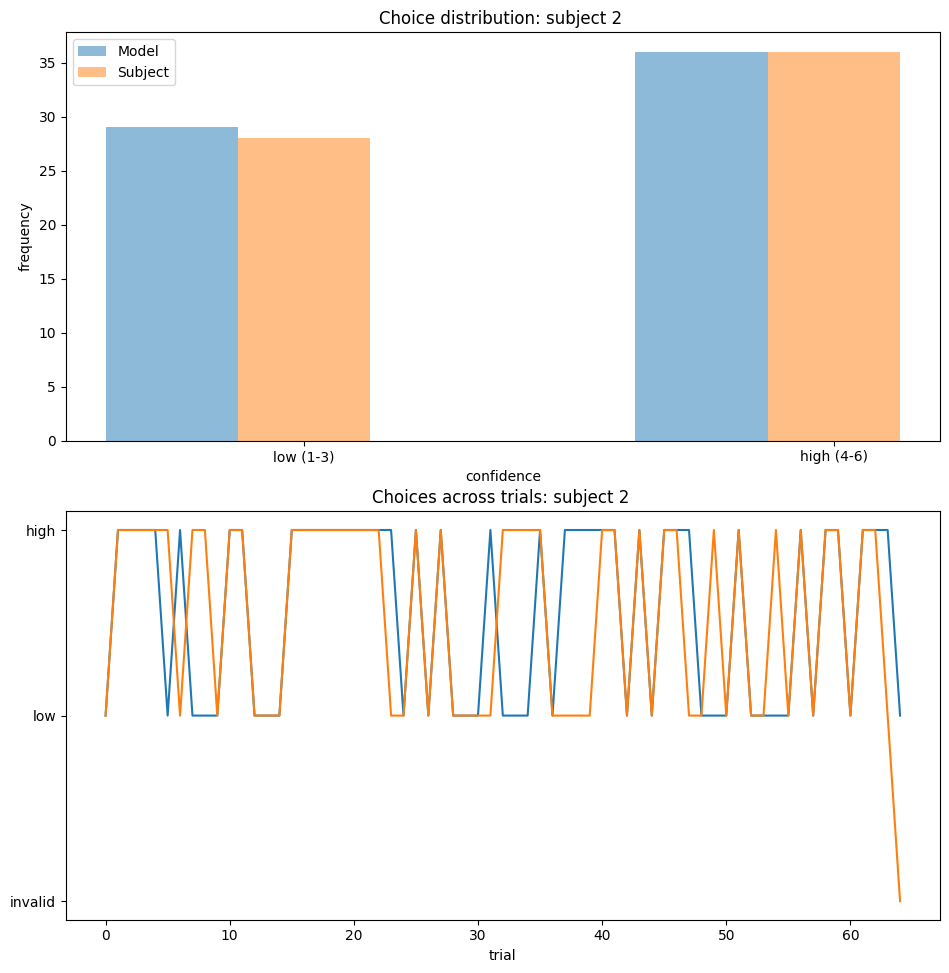

In [287]:
for i in range(model_outputs.shape[1]):

    model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
    model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))

    subject_choice = actual_choices[:, i]
    subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
    
    # Plot the distribution of choices for each subject
    labels = ("low (1-3)", "high (4-6)")
    all_choices = {'Model': model_counts, 'Subject': subject_counts}
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    #fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig, ax = plt.subplots(2, 1, figsize = (10, 10))
    fig.tight_layout(pad=3.0)

    for identity, count in all_choices.items():
        offset = width * multiplier
        rects = ax[0].bar(x + offset, count, width, alpha=0.5, label=identity)
        multiplier += 1

    ax[0].set_ylabel('frequency')
    ax[0].set_xlabel('confidence')
    ax[0].set_title('Choice distribution: subject {subject} '.format(subject=i+1))
    ax[0].set_xticks(x + width, labels)
    ax[0].legend(loc='upper left')
    
    # Plot the choices across all trials
    ax[1].plot(model_choice, label='Model')
    ax[1].plot(subject_choice, label='Subject')
    
    ax[1].set_xlabel('trial')
    ax[1].set_yticks([-1,0,1], labels=['invalid', 'low', 'high'])
    ax[1].set_title('Choices across trials: subject {subject} '.format(subject=i+1))

    plt.show()